In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import json

W = 60
H = 15

TRAINING_STRIDE = 1
INFERENCE_STRIDE = 1

TRAIN_RATIO = 0.65
VAL_RATIO = 0.20
TEST_RATIO = 0.15


In [9]:
DATASET_VERSION = 'v2'

if DATASET_VERSION == 'baseline':
    dataset_path = '../data/synthetic_data_baseline.csv'
    intervals_path = '../src/incident_intervals_baseline.json'
    print(f"Loading BASELINE dataset: {dataset_path}")

elif DATASET_VERSION == 'v2':
    dataset_path = '../data/synthetic_data_v2_improved.csv'
    intervals_path = '../src/incident_intervals_v2_improved.json'
    print(f"Loading V2 IMPROVED dataset: {dataset_path}")

else:
    raise ValueError(f"Unknown dataset version: {DATASET_VERSION}")

df = pd.read_csv(dataset_path)
df['timestamp'] = pd.to_datetime(df['timestamp'])

with open(intervals_path, 'r') as f:
    incident_intervals = json.load(f)

print(f"   Shape: {df.shape}")
print(f"   Timesteps: {len(df)}")
print(f"   Incidents: {len(incident_intervals)}")
print(f"   Incident rate: {(df['incident_label']==1).sum()/len(df)*100:.2f}%")

print(f"\nColumns: {list(df.columns)}")
print(f"\nFirst 3 rows:")
print(df.head(3))

Loading V2 IMPROVED dataset: synthetic_data_v2_improved.csv
   Shape: (20000, 7)
   Timesteps: 20000
   Incidents: 15
   Incident rate: 2.41%

Columns: ['timestamp', 'cpu_utilization', 'memory_usage', 'request_latency', 'error_rate', 'request_rate', 'incident_label']

First 3 rows:
            timestamp  cpu_utilization  memory_usage  request_latency  \
0 2026-01-01 00:00:00        48.656292     64.193775       145.968877   
1 2026-01-01 00:01:00        49.097236     64.494160       147.019569   
2 2026-01-01 00:02:00        48.835950     64.346993       145.886189   

   error_rate  request_rate  incident_label  
0    0.531258    946.251699               0  
1    0.631510    960.060586               0  
2    0.564813    944.574530               0  


In [10]:
def create_sliding_windows(df, W, H, stride, metric_columns):
    """
    Mathematical formulation:
    - Input window at time t: W_t = {x_{t-W+1}, ..., x_t}
    - Target label: Y_t = 1 if incident in {t+1, ..., t+H}, else 0
    - Training sample: X_t → y_t
    """

    n_timesteps = len(df)
    n_metrics = len(metric_columns)
    metrics = df[metric_columns].values
    labels = df['incident_label'].values

    start_idx = W
    end_idx = n_timesteps - H
    sample_indices = np.arange(start_idx, end_idx, stride)
    n_samples = len(sample_indices)

    print(f"  Valid range: [{start_idx}, {end_idx})")
    print(f"  Stride: {stride}")
    print(f"  Number of samples: {n_samples}")

    X = np.zeros((n_samples, W, n_metrics), dtype=np.float32)
    y = np.zeros(n_samples, dtype=np.int32)

    for i, t in enumerate(sample_indices):
        # Input window: [t-W, t) (last W timesteps before t)
        window_start = t - W
        window_end = t
        X[i] = metrics[window_start:window_end, :]

        # Target label: check if ANY incident in [t+1, t+H]
        # Note: I check [t+1, t+H+1) because Python slicing is exclusive
        future_start = t + 1
        future_end = t + H + 1
        y[i] = int(labels[future_start:future_end].any())

    n_positive = (y == 1).sum()
    n_negative = (y == 0).sum()

    print(f"   X shape: {X.shape}")
    print(f"   y shape: {y.shape}")
    print(f"   Class distribution:")
    print(f"     Negative (0): {n_negative:5d} ({n_negative/n_samples*100:5.2f}%)")
    print(f"     Positive (1): {n_positive:5d} ({n_positive/n_samples*100:5.2f}%)")
    print(f"   Class imbalance ratio: {n_negative/max(n_positive, 1):.1f}:1")

    return X, y, sample_indices


metric_columns = ['cpu_utilization', 'memory_usage', 'request_latency',
                  'error_rate', 'request_rate']

print(f"\n{'='*70}")
print("TESTING SLIDING WINDOW CREATION")
print(f"{'='*70}")

X_test, y_test, indices_test = create_sliding_windows(
    df, W, H,
    stride=TRAINING_STRIDE,  # Use training stride for this test
    metric_columns=metric_columns
)


TESTING SLIDING WINDOW CREATION
  Valid range: [60, 19985)
  Stride: 1
  Number of samples: 19925
   X shape: (19925, 60, 5)
   y shape: (19925,)
   Class distribution:
     Negative (0): 19246 (96.59%)
     Positive (1):   679 ( 3.41%)
   Class imbalance ratio: 28.3:1


In [11]:
def create_temporal_splits(df, W, H, train_ratio, val_ratio, test_ratio,
                          metric_columns, training_stride):
    """
    CRITICAL: I use chronological split (no random shuffle!)
    - Train: earliest portion (65%)
    - Val: middle portion (20%)
    - Test: latest portion (15%)
    """

    n_timesteps = len(df)
    train_end = int(n_timesteps * train_ratio)
    val_end = int(n_timesteps * (train_ratio + val_ratio))

    print(f"\n{'='*70}")
    print("TEMPORAL TRAIN/VAL/TEST SPLIT")
    print(f"{'='*70}")
    print(f"Total timesteps: {n_timesteps}")
    print(f"\nSplit boundaries:")
    print(f"  Train: [0 → {train_end}] ({train_ratio:.0%})")
    print(f"  Val:   [{train_end} → {val_end}] ({val_ratio:.0%})")
    print(f"  Test:  [{val_end} → {n_timesteps}] ({test_ratio:.0%})")

    df_train = df.iloc[:train_end].copy()
    df_val = df.iloc[train_end:val_end].copy()
    df_test = df.iloc[val_end:].copy()

    print(f"\nCreating training samples (stride={training_stride})...")
    X_train, y_train, train_indices = create_sliding_windows(
        df_train, W, H, stride=training_stride, metric_columns=metric_columns
    )

    print(f"\nCreating validation samples (stride={training_stride})...")
    X_val, y_val, val_indices = create_sliding_windows(
        df_val, W, H, stride=training_stride, metric_columns=metric_columns
    )
    # Adjust indices to global timeline
    val_indices = val_indices + train_end

    print(f"\nCreating test samples (stride={training_stride})...")
    X_test, y_test, test_indices = create_sliding_windows(
        df_test, W, H, stride=training_stride, metric_columns=metric_columns
    )
    test_indices = test_indices + val_end

    print(f"\n{'='*70}")
    print("SPLIT SUMMARY")
    print(f"{'='*70}")
    print(f"{'Split':<10} {'Timesteps':<12} {'Samples':<10} {'Positive':>10} {'Negative':>10} {'Pos%':>8}")
    print("-"*70)

    for split_name, X, y in [('Train', X_train, y_train),
                             ('Val', X_val, y_val),
                             ('Test', X_test, y_test)]:
        n_pos = (y == 1).sum()
        n_neg = (y == 0).sum()
        pos_pct = n_pos / len(y) * 100

        if split_name == 'Train':
            ts_count = train_end
        elif split_name == 'Val':
            ts_count = val_end - train_end
        else:
            ts_count = n_timesteps - val_end

        print(f"{split_name:<10} {ts_count:<12} {len(y):<10} {n_pos:>10} {n_neg:>10} {pos_pct:>7.2f}%")

    return {
        'X_train': X_train, 'y_train': y_train, 'train_indices': train_indices,
        'X_val': X_val, 'y_val': y_val, 'val_indices': val_indices,
        'X_test': X_test, 'y_test': y_test, 'test_indices': test_indices,
        'train_end': train_end, 'val_end': val_end
    }


splits = create_temporal_splits(
    df, W, H,
    train_ratio=TRAIN_RATIO,
    val_ratio=VAL_RATIO,
    test_ratio=TEST_RATIO,
    metric_columns=metric_columns,
    training_stride=TRAINING_STRIDE
)


TEMPORAL TRAIN/VAL/TEST SPLIT
Total timesteps: 20000

Split boundaries:
  Train: [0 → 13000] (65%)
  Val:   [13000 → 17000] (20%)
  Test:  [17000 → 20000] (15%)

Creating training samples (stride=1)...
  Valid range: [60, 12985)
  Stride: 1
  Number of samples: 12925
   X shape: (12925, 60, 5)
   y shape: (12925,)
   Class distribution:
     Negative (0): 12634 (97.75%)
     Positive (1):   291 ( 2.25%)
   Class imbalance ratio: 43.4:1

Creating validation samples (stride=1)...
  Valid range: [60, 3985)
  Stride: 1
  Number of samples: 3925
   X shape: (3925, 60, 5)
   y shape: (3925,)
   Class distribution:
     Negative (0):  3868 (98.55%)
     Positive (1):    57 ( 1.45%)
   Class imbalance ratio: 67.9:1

Creating test samples (stride=1)...
  Valid range: [60, 2985)
  Stride: 1
  Number of samples: 2925
   X shape: (2925, 60, 5)
   y shape: (2925,)
   Class distribution:
     Negative (0):  2594 (88.68%)
     Positive (1):   331 (11.32%)
   Class imbalance ratio: 7.8:1

SPLIT SUMMA

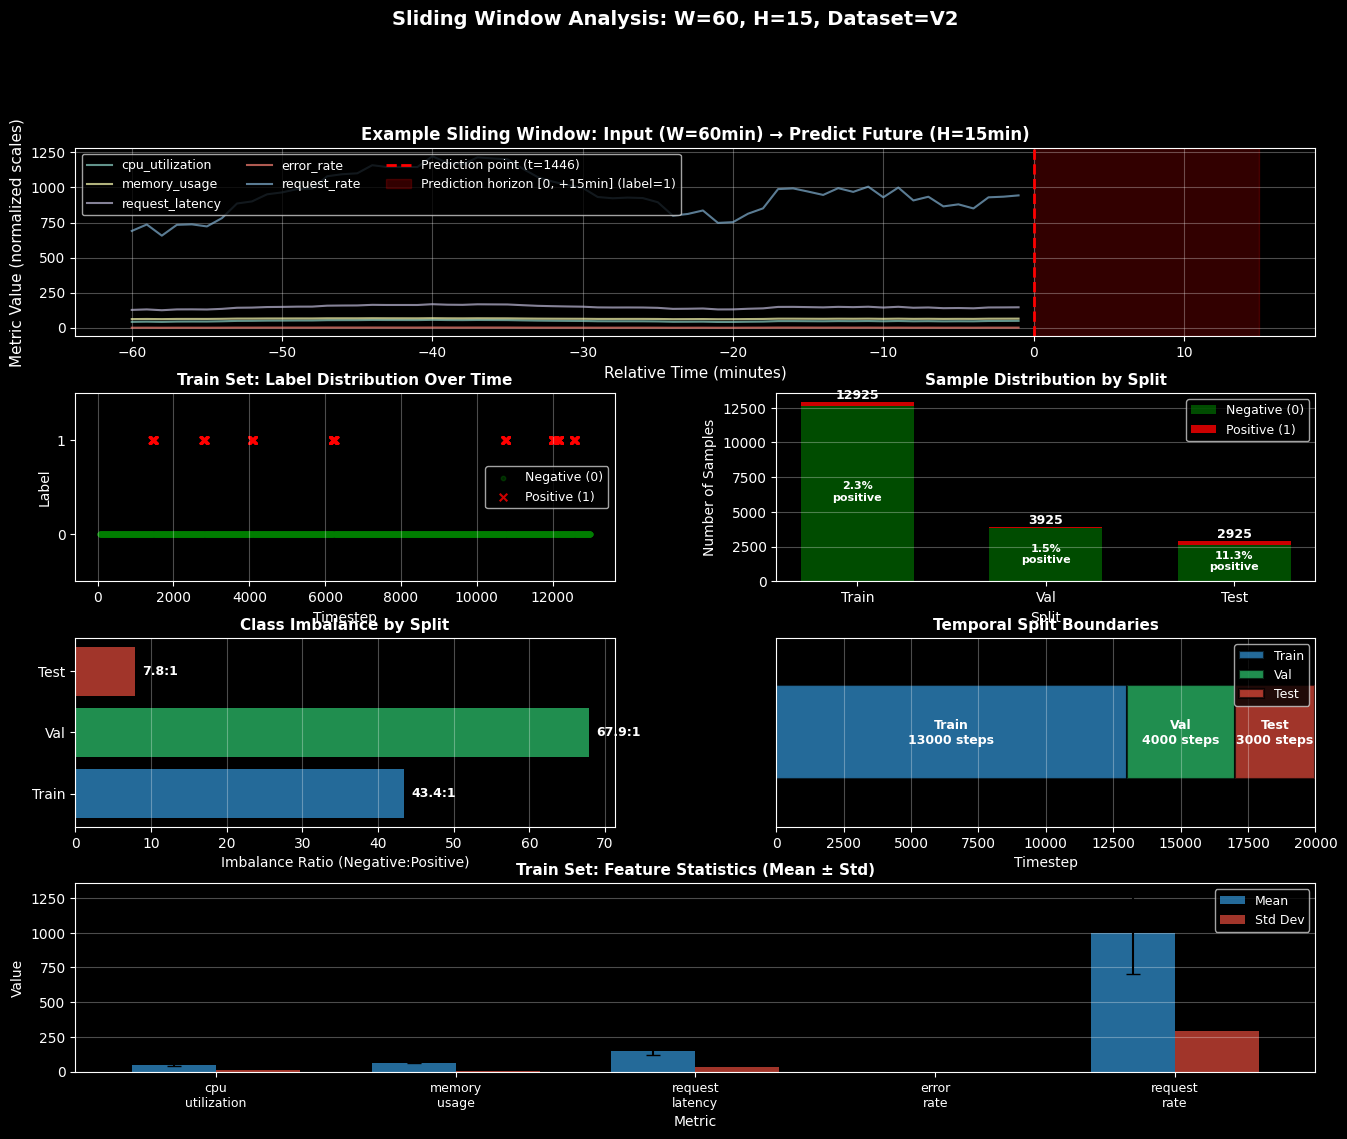

In [12]:
fig = plt.figure(figsize=(16, 12))
gs = fig.add_gridspec(4, 2, hspace=0.3, wspace=0.3)

ax1 = fig.add_subplot(gs[0, :])

positive_samples = np.where(splits['y_train'] == 1)[0]
if len(positive_samples) > 0:
    example_idx = positive_samples[0]
    example_window = splits['X_train'][example_idx]  # Shape: (60, 5)
    example_label = splits['y_train'][example_idx]
    example_timestep = splits['train_indices'][example_idx]

    # Plot all 5 metrics in the window
    time_in_window = np.arange(-W, 0)  # Relative time: -60 to 0

    for metric_idx, metric_name in enumerate(metric_columns):
        ax1.plot(time_in_window, example_window[:, metric_idx],
                label=metric_name, alpha=0.7, linewidth=1.5)

    ax1.axvline(0, color='red', linestyle='--', linewidth=2,
               label=f'Prediction point (t={example_timestep})')
    ax1.axvspan(0, H, alpha=0.2, color='red',
               label=f'Prediction horizon [0, +{H}min] (label={example_label})')

    ax1.set_xlabel('Relative Time (minutes)', fontsize=11)
    ax1.set_ylabel('Metric Value (normalized scales)', fontsize=11)
    ax1.set_title(f'Example Sliding Window: Input (W={W}min) → Predict Future (H={H}min)',
                 fontsize=12, fontweight='bold')
    ax1.legend(loc='upper left', ncol=3, fontsize=9)
    ax1.grid(True, alpha=0.3)

ax2 = fig.add_subplot(gs[1, 0])

train_timeline = splits['train_indices']
train_labels = splits['y_train']

ax2.scatter(train_timeline[train_labels == 0],
           np.zeros((train_labels == 0).sum()),
           c='green', alpha=0.3, s=10, label='Negative (0)')
ax2.scatter(train_timeline[train_labels == 1],
           np.ones((train_labels == 1).sum()),
           c='red', alpha=0.8, s=30, marker='x', label='Positive (1)')

ax2.set_xlabel('Timestep', fontsize=10)
ax2.set_ylabel('Label', fontsize=10)
ax2.set_ylim(-0.5, 1.5)
ax2.set_yticks([0, 1])
ax2.set_title('Train Set: Label Distribution Over Time', fontsize=11, fontweight='bold')
ax2.legend(fontsize=9)
ax2.grid(True, alpha=0.3, axis='x')

ax3 = fig.add_subplot(gs[1, 1])

split_data = [
    ('Train', len(splits['y_train']), (splits['y_train'] == 1).sum()),
    ('Val', len(splits['y_val']), (splits['y_val'] == 1).sum()),
    ('Test', len(splits['y_test']), (splits['y_test'] == 1).sum())
]

split_names = [x[0] for x in split_data]
n_samples = [x[1] for x in split_data]
n_positive = [x[2] for x in split_data]
n_negative = [n - p for n, p in zip(n_samples, n_positive)]

x_pos = np.arange(len(split_names))
width = 0.6

ax3.bar(x_pos, n_negative, width, label='Negative (0)', color='green', alpha=0.6)
ax3.bar(x_pos, n_positive, width, bottom=n_negative, label='Positive (1)',
       color='red', alpha=0.8)

ax3.set_xlabel('Split', fontsize=10)
ax3.set_ylabel('Number of Samples', fontsize=10)
ax3.set_title('Sample Distribution by Split', fontsize=11, fontweight='bold')
ax3.set_xticks(x_pos)
ax3.set_xticklabels(split_names)
ax3.legend(fontsize=9)
ax3.grid(True, alpha=0.3, axis='y')

# Add percentage labels on bars
for i, (name, total, pos) in enumerate(split_data):
    pos_pct = pos / total * 100
    ax3.text(i, total + 20, f'{total}', ha='center', va='bottom', fontsize=9, fontweight='bold')
    ax3.text(i, total/2, f'{pos_pct:.1f}%\npositive', ha='center', va='center',
            fontsize=8, color='white', fontweight='bold')

ax4 = fig.add_subplot(gs[2, 0])

imbalance_ratios = []
for name, total, pos in split_data:
    neg = total - pos
    ratio = neg / max(pos, 1)
    imbalance_ratios.append(ratio)

ax4.barh(split_names, imbalance_ratios, color=['#3498db', '#2ecc71', '#e74c3c'], alpha=0.7)
ax4.set_xlabel('Imbalance Ratio (Negative:Positive)', fontsize=10)
ax4.set_title('Class Imbalance by Split', fontsize=11, fontweight='bold')
ax4.grid(True, alpha=0.3, axis='x')

for i, ratio in enumerate(imbalance_ratios):
    ax4.text(ratio + 1, i, f'{ratio:.1f}:1', va='center', fontsize=9, fontweight='bold')

ax5 = fig.add_subplot(gs[2, 1])

timeline_ranges = [
    (0, splits['train_end'], 'Train', '#3498db'),
    (splits['train_end'], splits['val_end'], 'Val', '#2ecc71'),
    (splits['val_end'], len(df), 'Test', '#e74c3c')
]

for start, end, label, color in timeline_ranges:
    ax5.barh(0, end - start, left=start, height=0.5, color=color,
            alpha=0.7, label=label, edgecolor='black', linewidth=1.5)
    center = (start + end) / 2
    ax5.text(center, 0, f'{label}\n{end-start} steps',
            ha='center', va='center', fontsize=9, fontweight='bold', color='white')

ax5.set_xlim(0, len(df))
ax5.set_ylim(-0.5, 0.5)
ax5.set_xlabel('Timestep', fontsize=10)
ax5.set_yticks([])
ax5.set_title('Temporal Split Boundaries', fontsize=11, fontweight='bold')
ax5.legend(loc='upper right', fontsize=9)
ax5.grid(True, alpha=0.3, axis='x')

ax6 = fig.add_subplot(gs[3, :])

# Calculate mean and std for each metric across all train samples
train_means = splits['X_train'].mean(axis=(0, 1))  # Mean across samples and time
train_stds = splits['X_train'].std(axis=(0, 1))    # Std across samples and time

x_pos = np.arange(len(metric_columns))
width = 0.35

ax6.bar(x_pos - width/2, train_means, width, label='Mean',
       color='#3498db', alpha=0.7, yerr=train_stds, capsize=5)
ax6.bar(x_pos + width/2, train_stds, width, label='Std Dev',
       color='#e74c3c', alpha=0.7)

ax6.set_xlabel('Metric', fontsize=10)
ax6.set_ylabel('Value', fontsize=10)
ax6.set_title('Train Set: Feature Statistics (Mean ± Std)', fontsize=11, fontweight='bold')
ax6.set_xticks(x_pos)
ax6.set_xticklabels([m.replace('_', '\n') for m in metric_columns], fontsize=9)
ax6.legend(fontsize=9)
ax6.grid(True, alpha=0.3, axis='y')

plt.suptitle(f'Sliding Window Analysis: W={W}, H={H}, Dataset={DATASET_VERSION.upper()}',
            fontsize=14, fontweight='bold', y=0.995)
plt.show()


In [13]:
print(f"\n{'='*70}")
print("DETAILED SAMPLE ANALYSIS")
print(f"{'='*70}")

print(f"\n1. Positive Sample Distribution:")
print(f"   {'Split':<10} {'Total':>8} {'Positive':>10} {'Percentage':>12}")
print(f"   {'-'*50}")

for split_name, y in [('Train', splits['y_train']),
                      ('Val', splits['y_val']),
                      ('Test', splits['y_test'])]:
    n_total = len(y)
    n_pos = (y == 1).sum()
    pct = n_pos / n_total * 100
    print(f"   {split_name:<10} {n_total:>8} {n_pos:>10} {pct:>11.2f}%")

print(f"\n2. Data Leakage Check:")
print(f"   Training stride: {TRAINING_STRIDE} minutes")
print(f"   Prediction horizon: {H} minutes")

if TRAINING_STRIDE >= H:
    print(f"   NO LEAKAGE: stride ({TRAINING_STRIDE}) >= horizon ({H})")
    print(f"      → Prediction windows do NOT overlap")
else:
    print(f"   POTENTIAL LEAKAGE: stride ({TRAINING_STRIDE}) < horizon ({H})")
    print(f"      → Prediction windows overlap by {H - TRAINING_STRIDE} timesteps")

print(f"\n3. Dataset Coverage:")
total_timesteps = len(df)
train_samples = len(splits['y_train'])
val_samples = len(splits['y_val'])
test_samples = len(splits['y_test'])

train_coverage = train_samples * TRAINING_STRIDE / splits['train_end'] * 100
val_coverage = val_samples * TRAINING_STRIDE / (splits['val_end'] - splits['train_end']) * 100
test_coverage = test_samples * TRAINING_STRIDE / (total_timesteps - splits['val_end']) * 100

print(f"   {'Split':<10} {'Samples':>10} {'Timesteps':>12} {'Coverage':>10}")
print(f"   {'-'*50}")
print(f"   {'Train':<10} {train_samples:>10} {splits['train_end']:>12} {train_coverage:>9.1f}%")
print(f"   {'Val':<10} {val_samples:>10} {splits['val_end'] - splits['train_end']:>12} {val_coverage:>9.1f}%")
print(f"   {'Test':<10} {test_samples:>10} {total_timesteps - splits['val_end']:>12} {test_coverage:>9.1f}%")

print(f"\n4. Memory Usage:")

def get_array_size_mb(arr):
    return arr.nbytes / (1024 ** 2)

total_size = 0
for name, arr in [('X_train', splits['X_train']), ('y_train', splits['y_train']),
                  ('X_val', splits['X_val']), ('y_val', splits['y_val']),
                  ('X_test', splits['X_test']), ('y_test', splits['y_test'])]:
    size_mb = get_array_size_mb(arr)
    total_size += size_mb
    print(f"   {name:<10}: {size_mb:>8.2f} MB  (shape: {arr.shape})")

print(f"   {'-'*50}")
print(f"   {'Total':<10}: {total_size:>8.2f} MB")

print(f"\n5. Sample Index Ranges:")
print(f"   {'Split':<10} {'First Index':>15} {'Last Index':>15} {'Span':>10}")
print(f"   {'-'*50}")

for split_name, indices in [('Train', splits['train_indices']),
                            ('Val', splits['val_indices']),
                            ('Test', splits['test_indices'])]:
    first = indices[0]
    last = indices[-1]
    span = last - first
    print(f"   {split_name:<10} {first:>15} {last:>15} {span:>10}")

def incident_covered_by_samples(pos_t, start, end, W, H, n_total):
    """
    Incident interval: [start, end)  (end excluded)
    Prediction window of sample at time t: [t+1, t+H+1)
    I want ANY positive sample whose prediction window intersects the incident interval.
    """

    # t must be in [start-H, end-2] to intersect (integer t)
    lo = max(W, start - H)
    hi = min(n_total - H - 1, end - 2)

    if hi < lo:
        return False

    return np.any((pos_t >= lo) & (pos_t <= hi))


print("\n6. Incident Alignment with Labels:")
print("   Checking if incidents have at least one positive sample (across ALL splits)...")

train_pos = splits["train_indices"][splits["y_train"] == 1]
val_pos   = splits["val_indices"][splits["y_val"] == 1]
test_pos  = splits["test_indices"][splits["y_test"] == 1]
pos_all = np.concatenate([train_pos, val_pos, test_pos])

covered = 0
total = len(incident_intervals)

for inc in incident_intervals:
    start = int(inc["start_idx"]) if DATASET_VERSION == "v2" else int(inc[0])
    end   = int(inc["end_idx"])   if DATASET_VERSION == "v2" else int(inc[1])

    if incident_covered_by_samples(pos_all, start, end, W, H, len(df)):
        covered += 1

pct = covered / max(total, 1) * 100
print(f"   Incidents with positive samples: {covered}/{total} ({pct:.1f}%)")


DETAILED SAMPLE ANALYSIS

1. Positive Sample Distribution:
   Split         Total   Positive   Percentage
   --------------------------------------------------
   Train         12925        291        2.25%
   Val            3925         57        1.45%
   Test           2925        331       11.32%

2. Data Leakage Check:
   Training stride: 1 minutes
   Prediction horizon: 15 minutes
   POTENTIAL LEAKAGE: stride (1) < horizon (15)
      → Prediction windows overlap by 14 timesteps

3. Dataset Coverage:
   Split         Samples    Timesteps   Coverage
   --------------------------------------------------
   Train           12925        13000      99.4%
   Val              3925         4000      98.1%
   Test             2925         3000      97.5%

4. Memory Usage:
   X_train   :    14.79 MB  (shape: (12925, 60, 5))
   y_train   :     0.05 MB  (shape: (12925,))
   X_val     :     4.49 MB  (shape: (3925, 60, 5))
   y_val     :     0.01 MB  (shape: (3925,))
   X_test    :     3.35 MB 

In [14]:
import json
def get_array_size_mb(arr) -> float:
    return arr.nbytes / (1024**2)


output_prefix = f"../data/sliding_window_{DATASET_VERSION}_W{W}_H{H}"

np.savez_compressed(
    f"{output_prefix}.npz",
    X_train=splits["X_train"],
    y_train=splits["y_train"],
    X_val=splits["X_val"],
    y_val=splits["y_val"],
    X_test=splits["X_test"],
    y_test=splits["y_test"],
    train_indices=splits["train_indices"],
    val_indices=splits["val_indices"],
    test_indices=splits["test_indices"],
    metric_columns=np.array(metric_columns, dtype=object)
)

total_size = sum(
    get_array_size_mb(splits[k]) for k in ["X_train", "y_train", "X_val", "y_val", "X_test", "y_test"]
)

print(f"Saved: {output_prefix}.npz ({total_size:.1f} MB)")

coverage = int((df["incident_label"] == 1).sum())
incident_rate_pct = float(coverage / len(df) * 100)

metadata = {
    "dataset_version": str(DATASET_VERSION),
    "dataset_path": str(dataset_path),
    "n_timesteps_total": int(len(df)),
    "n_incidents": int(len(incident_intervals)),
    "incident_rate_pct": incident_rate_pct,

    "sliding_window_params": {
        "W": int(W),
        "H": int(H),
        "training_stride": int(TRAINING_STRIDE),
        "inference_stride": int(INFERENCE_STRIDE),
    },

    "split_params": {
        "train_ratio": float(TRAIN_RATIO),
        "val_ratio": float(VAL_RATIO),
        "test_ratio": float(TEST_RATIO),
        "train_end": int(splits["train_end"]),
        "val_end": int(splits["val_end"]),
    },

    "metric_columns": [str(c) for c in metric_columns],

    "data_shapes": {
        "X_train": [int(x) for x in splits["X_train"].shape],
        "y_train": [int(x) for x in splits["y_train"].shape],
        "X_val": [int(x) for x in splits["X_val"].shape],
        "y_val": [int(x) for x in splits["y_val"].shape],
        "X_test": [int(x) for x in splits["X_test"].shape],
        "y_test": [int(x) for x in splits["y_test"].shape],
    },

    "class_distribution": {
        "train": {
            "negative": int((splits["y_train"] == 0).sum()),
            "positive": int((splits["y_train"] == 1).sum()),
            "positive_pct": float((splits["y_train"] == 1).sum() / len(splits["y_train"]) * 100),
        },
        "val": {
            "negative": int((splits["y_val"] == 0).sum()),
            "positive": int((splits["y_val"] == 1).sum()),
            "positive_pct": float((splits["y_val"] == 1).sum() / len(splits["y_val"]) * 100),
        },
        "test": {
            "negative": int((splits["y_test"] == 0).sum()),
            "positive": int((splits["y_test"] == 1).sum()),
            "positive_pct": float((splits["y_test"] == 1).sum() / len(splits["y_test"]) * 100),
        },
    },

    "memory_usage_mb": {
        "X_train": float(get_array_size_mb(splits["X_train"])),
        "X_val": float(get_array_size_mb(splits["X_val"])),
        "X_test": float(get_array_size_mb(splits["X_test"])),
        "total": float(total_size),
    },
}

with open(f"{output_prefix}_metadata.json", "w", encoding="utf-8") as f:
    json.dump(metadata, f, indent=2, ensure_ascii=False)

print(f"Saved: {output_prefix}_metadata.json")
print("Done. Sliding window data ready for training.")


Saved: sliding_window_v2_W60_H15.npz (22.7 MB)
Saved: sliding_window_v2_W60_H15_metadata.json
Done. Sliding window data ready for training.
